In [1]:
# Importing necessary libraries
import deepxde as dde
from deepxde.backend import tf
import numpy as np

Using backend: paddle
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, jax.
paddle supports more examples now and is recommended.


In [2]:
def gen_testdata():
    data = np.load("Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

In [3]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

In [4]:
data = dde.data.TimePDE(geomtime, pde, [bc, ic],
                        num_domain=2500, num_boundary=100, num_initial=100)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

In [5]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=10000)
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.000164 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.28e-02, 1.23e-02, 5.43e-01]    [3.28e-02, 1.23e-02, 5.43e-01]    []  
1000      [4.32e-02, 1.33e-03, 5.93e-02]    [4.32e-02, 1.33e-03, 5.93e-02]    []  
2000      [3.42e-02, 2.47e-04, 4.75e-02]    [3.42e-02, 2.47e-04, 4.75e-02]    []  
3000      [2.11e-02, 8.66e-05, 2.57e-02]    [2.11e-02, 8.66e-05, 2.57e-02]    []  
4000      [1.63e-02, 3.02e-05, 1.45e-02]    [1.63e-02, 3.02e-05, 1.45e-02]    []  
5000      [9.19e-03, 2.85e-05, 5.61e-03]    [9.19e-03, 2.85e-05, 5.61e-03]    []  
6000      [5.58e-03, 2.10e-05, 3.65e-03]    [5.58e-03, 2.10e-05, 3.65e-03]    []  
7000      [3.97e-03, 6.59e-06, 2.88e-03]    [3.97e-03, 6.59e-06, 2.88e-03]    []  
8000      [3.20e-03, 4.59e-06, 2.49e-03]    [3.20e-03, 4.59e-06, 2.49e-03]    []  
9000      [2.83e-03, 3.23e-06, 2.13e-03]    [2.83e-03, 3.23e-06, 2.13e-03]    []  
10000     [6.68

In [6]:
X = geomtime.random_points(100000)
err = 1

In [7]:
while err > 0.005:
    f = model.predict(X, operator=pde)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))

    x_id = np.argmax(err_eq)
    print("Adding new point:", X[x_id], "\n")
    data.add_anchors(X[x_id])
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    model.compile("adam", lr=1e-3)
    model.train(iterations=10000, disregard_previous_best=True, callbacks=[early_stopping])
    model.compile("L-BFGS")
    losshistory, train_state = model.train()

Mean residual: 2.386e-03
Adding new point: [-0.00251341  0.4580517 ] 

Compiling model...
'compile' took 0.000189 s

Training model...

Step      Train loss                        Test loss                         Test metric
25000     [9.38e-05, 2.65e-08, 3.72e-07]    [6.16e-06, 2.65e-08, 3.72e-07]    []  
26000     [1.37e-05, 2.87e-08, 1.30e-06]    [1.24e-05, 2.87e-08, 1.30e-06]    []  
27000     [1.39e-05, 3.84e-08, 2.29e-06]    [1.31e-05, 3.84e-08, 2.29e-06]    []  
Epoch 27001: early stopping

Best model at step 26000:
  train loss: 1.50e-05
  test loss: 1.38e-05
  test metric: []

'train' took 22.777450 s

Compiling model...
'compile' took 0.000149 s

Training model...

Step      Train loss                        Test loss                         Test metric
27001     [1.51e-05, 2.98e-08, 2.47e-06]    [1.51e-05, 2.98e-08, 2.47e-06]    []  
28001     [6.75e-06, 2.66e-08, 4.32e-07]    [6.74e-06, 2.66e-08, 4.32e-07]    []  
29001     [6.74e-06, 2.69e-08, 4.31e-07]    [6.73e-06, 2.69

Saving loss history to d:\GitHub\uis-pinns-research\loss.dat ...
Saving training data to d:\GitHub\uis-pinns-research\train.dat ...
Saving test data to d:\GitHub\uis-pinns-research\test.dat ...


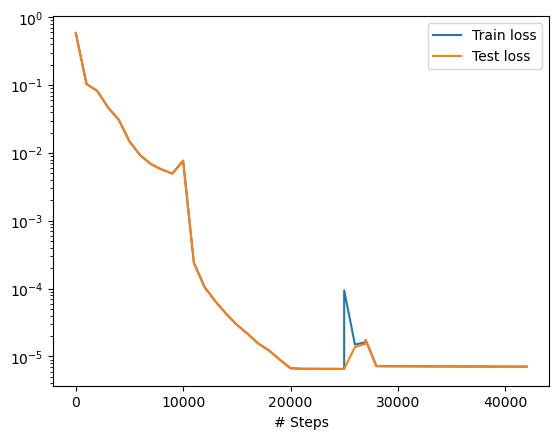

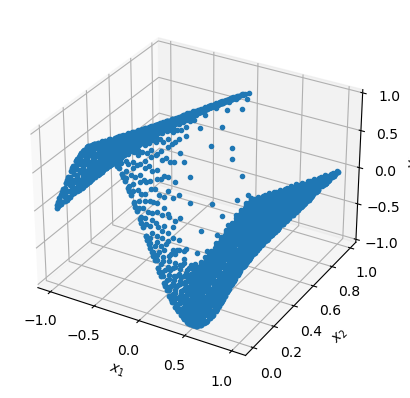

L2 relative error: 0.005549560478986296


In [8]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

X, y_true = gen_testdata()
y_pred = model.predict(X)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))